In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [19]:
del(encoder)
del(decoder)
del(vae)

NameError: name 'decoder' is not defined

In [10]:
binary_crossentropy(x, x_decoded_mean)

<tf.Tensor 'Mean:0' shape=(?,) dtype=float32>

In [14]:
1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)

<tf.Tensor 'sub_9:0' shape=(?, 64) dtype=float32>

In [11]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(64,))
    out = z_mean + K.exp(z_log_sigma) * epsilon
    return out

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss


latent_dim=64
input_shape= 18*18*736
batch_size=32

x = Input(shape=(input_shape,), name='input')

h = Dense(256, activation='relu', name='h')(x)

z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')(h)

z = Lambda(sampling, name='lambda_sampling')([z_mean,z_log_sigma])

decoder_h = Dense(256, activation='relu', name='decoder_h')
decoder_mean = Dense(18*18*736, activation='sigmoid', name='decoder_mean')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, x_decoded_mean)
encoder = Model(x, z_mean)

decoder_input = Input(shape=(64,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 238464)       0                                            
__________________________________________________________________________________________________
h (Dense)                       (None, 256)          61047040    input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 64)           16448       h[0][0]                          
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 64)           16448       h[0][0]                          
__________________________________________________________________________________________________
lambda_sam

In [8]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.


In [5]:
with open('/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

with open('/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    ttest_labels, ttest_features = pickle.load(dt)

# s_labels = [k.split('/')[-2] for k in s_labels]
# sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
# s_features.shape, sval_features.shape, t_features.shape

In [6]:
s_features = s_features.reshape(len(s_features), 18*18*736)
sval_features = sval_features.reshape(len(sval_features), 18*18*736)

s_features.shape, sval_features.shape

((1576, 238464), (395, 238464))

## Amazon

In [ ]:
batch_size=32
mcp = ModelCheckpoint('/data/Quan/tf_models/amazon/vae_fc_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, sval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/vae_fc_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 1576 samples, validate on 395 samples
Epoch 1/100
1576/1576 [==============================] - 6s 4ms/step - loss: nan - val_loss: nan
Epoch 2/100
1576/1576 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 3/100
1576/1576 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 4/100
1576/1576 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 5/100
1576/1576 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 6/100
1576/1576 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 7/100
1576/1576 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 8/100
1576/1576 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 9/100
1576/1576 [==============================] - 4s 3ms/step - loss: nan - val_loss: nan
Epoch 10/100
1576/1576 [==============================] - 4s 3ms/step - loss: na

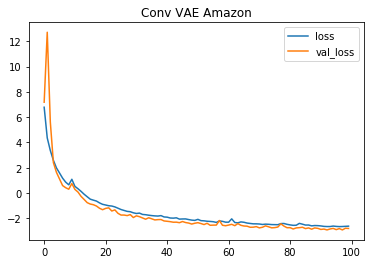

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Amazon')
plt.show()

## Webcam

In [8]:
batch_size=32
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/vae2_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(t_features, t_features, batch_size=batch_size, epochs=100, 
          validation_data=(tval_features, tval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/webcam/vae2_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 2ms/step - loss: 0.0683 - val_loss: -0.2721
Epoch 2/100
444/444 [==============================] - 1s 2ms/step - loss: 0.0092 - val_loss: -0.3134
Epoch 3/100
444/444 [==============================] - 1s 2ms/step - loss: -0.1594 - val_loss: -0.3682
Epoch 4/100
444/444 [==============================] - 1s 2ms/step - loss: -0.2736 - val_loss: -0.3851
Epoch 5/100
444/444 [==============================] - 1s 2ms/step - loss: -0.3460 - val_loss: -0.3599
Epoch 6/100
444/444 [==============================] - 1s 2ms/step - loss: -0.4060 - val_loss: -0.3065
Epoch 7/100
444/444 [==============================] - 1s 2ms/step - loss: -0.4334 - val_loss: -0.2791
Epoch 8/100
444/444 [==============================] - 1s 2ms/step - loss: -0.4890 - val_loss: -0.2823
Epoch 9/100
444/444 [==============================] - 1s 2ms/step - loss: -0.5039 - val_loss: -0.2616
Epoch 10/100
444/444 [=======

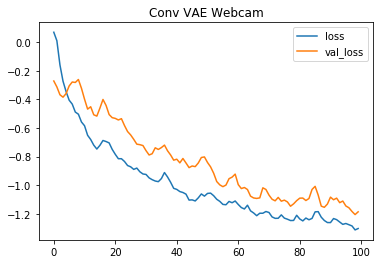

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Webcam')
plt.show()

## Combine VAE

In [11]:
import keras.losses
keras.losses.vae_loss = vae_loss

s_vae = load_model('/data/Quan/tf_models/amazon/vae2_model.hdf5',custom_objects={'latent_dim': latent_dim, 'loss': vae_loss(z_mean,z_log_var)})
t_vae = load_model('/data/Quan/tf_models/webcam/vae2_model.hdf5',custom_objects={'latent_dim': latent_dim, 'loss': vae_loss(z_mean,z_log_var)})

s_vae.summary()
t_vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
encoder (Model)              [(None, 18, 18, 128), (No 577536    
_________________________________________________________________
decoder (Model)              (None, 18, 18, 736)       548192    
Total params: 1,125,728
Trainable params: 1,121,184
Non-trainable params: 4,544
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
encoder (Model)              [(None, 18, 18, 128), (No 577536    
______________________________________________________________

In [12]:
t_encoder = Model(t_vae.get_layer('encoder').inputs, t_vae.get_layer('encoder').outputs, name='t_encoder')
s_decoder = Model(s_vae.get_layer('decoder').inputs, s_vae.get_layer('decoder').outputs, name='s_decoder')

t_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 18, 18, 512)  377344      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 18, 18, 512)  2048        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 18, 18, 256)  131328      batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [13]:
c_vae_outputs = s_decoder(t_encoder(t_encoder.inputs)[2])
c_vae = Model(t_encoder.inputs, c_vae_outputs, name='combined_vae')
c_vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
t_encoder (Model)            [(None, 18, 18, 128), (No 577536    
_________________________________________________________________
s_decoder (Model)            (None, 18, 18, 736)       548192    
Total params: 1,125,728
Trainable params: 1,121,184
Non-trainable params: 4,544
_________________________________________________________________


In [16]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_vae.predict(t_features, verbose=1)
val_transform_features = c_vae.predict(tval_features, verbose=1)
test_transform_features = c_vae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 1ms/step


In [17]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

W1213 11:43:48.749011 140416969307904 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1213 11:43:49.492885 140416969307904 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 736)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 31)                22847     
_________________________________________________________________
batch_normalization_6 (Batch (None, 31)                124       
_________________________________________________________________
activation_1 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [23]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 3ms/step


[4.008128966247686, 0.04184100418410042]

In [18]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=100,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 3ms/step - loss: 4.1012 - acc: 0.0541 - val_loss: 2.8004 - val_acc: 0.2143
Epoch 2/100
444/444 [==============================] - 0s 466us/step - loss: 3.0769 - acc: 0.1869 - val_loss: 2.3618 - val_acc: 0.3393
Epoch 3/100
444/444 [==============================] - 0s 462us/step - loss: 2.3607 - acc: 0.3536 - val_loss: 2.0638 - val_acc: 0.4643
Epoch 4/100
444/444 [==============================] - 0s 462us/step - loss: 1.9565 - acc: 0.4369 - val_loss: 1.8350 - val_acc: 0.5268
Epoch 5/100
444/444 [==============================] - 0s 466us/step - loss: 1.6868 - acc: 0.5315 - val_loss: 1.6545 - val_acc: 0.6161
Epoch 6/100
444/444 [==============================] - 0s 460us/step - loss: 1.4576 - acc: 0.6149 - val_loss: 1.5154 - val_acc: 0.6518
Epoch 7/100
444/444 [==============================] - 0s 464us/step - loss: 1.3735 - acc: 0.6464 - val_loss: 1.3973 - val_acc: 0.7143
Epoch 8/100

Epoch 61/100
444/444 [==============================] - 0s 462us/step - loss: 0.5113 - acc: 0.8919 - val_loss: 0.6419 - val_acc: 0.8929
Epoch 62/100
444/444 [==============================] - 0s 461us/step - loss: 0.5015 - acc: 0.8986 - val_loss: 0.6324 - val_acc: 0.8929
Epoch 63/100
444/444 [==============================] - 0s 462us/step - loss: 0.5429 - acc: 0.9009 - val_loss: 0.6262 - val_acc: 0.8929
Epoch 64/100
444/444 [==============================] - 0s 463us/step - loss: 0.5201 - acc: 0.8919 - val_loss: 0.6214 - val_acc: 0.8929
Epoch 65/100
444/444 [==============================] - 0s 459us/step - loss: 0.5341 - acc: 0.8671 - val_loss: 0.6245 - val_acc: 0.8839
Epoch 66/100
444/444 [==============================] - 0s 470us/step - loss: 0.5481 - acc: 0.8851 - val_loss: 0.6283 - val_acc: 0.8839
Epoch 67/100
444/444 [==============================] - 0s 478us/step - loss: 0.4693 - acc: 0.9144 - val_loss: 0.6304 - val_acc: 0.8750
Epoch 68/100
444/444 [==========================

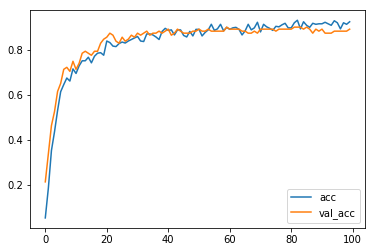

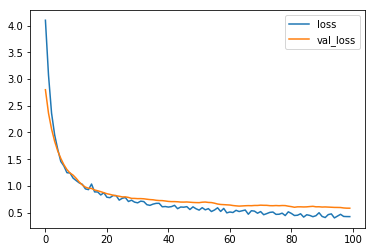

In [19]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [20]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 0s 2ms/step


[0.8929828470222122, 0.7782426790712269]